In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batchnum = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchnum, shuffle=True)

Using device: cpu


In [3]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.layers = nn.ModuleDict({
            'fc1': nn.Linear(784, 784),
            'fc2': nn.Linear(784, 400),
            'fc3': nn.Linear(400, 10)
        })

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(1, 4):
            layer = self.layers[f'fc{i}']
            x = F.relu(layer(x)) if i != 3 else layer(x)
        return x

    def get_layer_name(self, module):
        for name, mod in self.layers.items():
            if mod is module:
                return name
        return None


class ExplainableNetwork:
    def __init__(self, model):
        self.model = model
        self.gradients = {}
        self.current_epoch = 0
        self.num_epochs = 0
        self.node_inputs = []
        self.activations_stats = {}
        self.activations_per_input = {}
        self.gradients_per_input = {}
        self.batch_counter = 0
        self.last_layer_key = list(model.layers.keys())[-1]
        self.extreme_activations = {}
        self.activation_frequencies = {}
        self.inhook = 0
        self.backhook = 0
        self.expected_outputs = []
        self.predicted_outputs = []

    # Forward Hook that stores the activations of each node
    def input_hook(self, module, input, output):
        if self.current_epoch == self.num_epochs - 1:
            layer_name = self.model.get_layer_name(module)        
            self.inhook += 1
            batch_size = output.size(0)
            for i in range(batch_size):
                image_index = batch_size * self.batch_counter + i
                if image_index not in self.activations_per_input:
                    self.activations_per_input[image_index] = {}
        
                self.activations_per_input[image_index][layer_name] = output[i].detach().cpu().numpy()
                
            if layer_name == self.last_layer_key:
                self.batch_counter += 1

            for i in range(input[0].size(dim=0)):
                if np.shape(input[0][i]) == torch.Size([784]):
                    image = input[0][i].detach().reshape(28, 28).cpu().numpy()
                    self.node_inputs.append((layer_name, i, image))
                    
    # Hook that gets called during backpropagation, storing the backpropagated derivatives
    def backward_hook(self, module, grad_input, grad_output):
        self.backhook += 1
        layer_name = self.model.get_layer_name(module)
        batch_size = grad_output[0].size(0)
        for i in range(batch_size):
            image_index = batch_size * self.batch_counter + i
            if image_index not in self.gradients_per_input:
                self.gradients_per_input[image_index] = {}

            self.gradients_per_input[image_index][layer_name] = grad_output[0][i].detach().cpu().numpy()
    
    # Generic hook attaching, needed for any PyTorch hook implementation
    def attach_hooks(self):
        for layer_name in self.model.layers.keys():
            layer = self.model.layers[layer_name]

            layer.register_forward_hook(self.input_hook)

            layer.register_full_backward_hook(self.backward_hook)

    def set_epoch(self, epoch):
        self.current_epoch = epoch
                
    # Displays scatter plots for the activations for each node in each layer
    def visualize_activations_for_input(self, image_index, layers=None, node_index=None, color='ro'):
        if layers is None:
            layers = ['fc1', 'fc2', 'fc3']

        if node_index is not None:
            activations = [self.activations_per_input[idx][layers[0]][node_index] 
                            for idx in self.activations_per_input if layers[0] in self.activations_per_input[idx]]
            plt.figure(figsize=(10, 6))
            plt.plot(activations, color)
            plt.title(f'Activations of Neuron {node_index} in {layers[0]} Across Images')
            plt.xlabel('Image Index')
            plt.ylabel('Activation')
            plt.show()
        else:
            individual_activations = self.activations_per_input.get(image_index, {})
            for layer in layers:
                layer_activations = individual_activations.get(layer, None)
                if layer_activations is not None:
                    plt.figure(figsize=(10, 6))
                    plt.scatter(range(len(layer_activations)), layer_activations, label=layer)
                    plt.title(f'Activations in Layer {layer} for Image {image_index}')  # Set title with layer name
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Activation')
                    plt.legend()
                    plt.show()



    def print_all_activations(self):
        for image_index, layers_dict in self.activations_per_input.items():
            print(f"Image Index: {image_index}")
            for layer_name, activations in layers_dict.items():
                print(f"  Layer Name: {layer_name}")
                print(f"    Shape of Activations: {activations.shape}")
                print(f"    Sample Activations: {activations[:5]}")

    # Finds and stores inputs that correspond to node activations that are +/-std_dev_threshold away from the mean
    # Stores a dictionary of the ['high'] and ['low'] activations in self.extreme_activations
    def find_extreme_activations(self, std_dev_threshold=3):

        node_stats = {}
        for _, layers_activations in self.activations_per_input.items():
            for layer_name, activations in layers_activations.items():
                if layer_name not in node_stats:
                    node_stats[layer_name] = []
                node_stats[layer_name].append(activations)

        for layer_name, activations_list in node_stats.items():
            node_stats[layer_name] = {
                'mean': np.mean(activations_list, axis=0),
                'std': np.std(activations_list, axis=0)
            }

        extreme_activations = {'high': {}, 'low': {}}
        for input_index, layers_activations in self.activations_per_input.items():
            for layer_name, activations in layers_activations.items():
                mean = node_stats[layer_name]['mean']
                std = node_stats[layer_name]['std']
                high_threshold = mean + std_dev_threshold * std
                low_threshold = mean - std_dev_threshold * std

                high_indices = np.where(activations > high_threshold)[0]
                low_indices = np.where(activations < low_threshold)[0]

                for idx in high_indices:
                    extreme_activations['high'].setdefault((layer_name, idx), []).append(input_index)
                for idx in low_indices:
                    extreme_activations['low'].setdefault((layer_name, idx), []).append(input_index)
        self.extreme_activations = extreme_activations
        return extreme_activations

    # Stores a frequency map for the high and low activation to determine color in the greyscale mapping later
    # Creates the "activation structure" which is indexed by ['output_digit']['layer_name']['high/low']
    # There is a bug we are working on right now with the numbering of the activations causing pixels 0-9 will have a higher frequency
    def build_extreme_activation_structure(self):
        print(f"High activations count: {len(self.extreme_activations['high'])}")
        print(f"Low activations count: {len(self.extreme_activations['low'])}")
        
        num_digits = 10
        num_layers = 3
        activations_structure = [[[[] for _ in range(2)] for _ in range(num_layers)] for _ in range(num_digits)]
        
        processed_nodes = set()
    
        self.activation_frequencies['high'] = np.zeros(784 + 400 + 10)
        for (layer_name, node_index), input_indices in self.extreme_activations['high'].items():
            layer_index = self.get_layer_index(layer_name)
            for input_idx in input_indices:
                if input_idx < len(self.expected_outputs) and input_idx < len(self.predicted_outputs):
                    expected = self.expected_outputs[input_idx]
                    predicted = self.predicted_outputs[input_idx]
                    node_key = (expected, layer_index, 0, node_index)
                    if expected == predicted and node_key not in processed_nodes:
                        activations_structure[expected][layer_index][0].append(node_index)
                        processed_nodes.add(node_key)
                    elif expected == predicted:
                        self.activation_frequencies['high'][node_index] += 1
                    elif expected != predicted:
                        print(f"Mismatched Prediction: Input Index {input_idx}, Expected: {expected}, Predicted: {predicted}, Node: {node_index}, Layer: {layer_name}, High Activation")
        
        self.activation_frequencies['low'] = np.zeros(784 + 400 + 10)
        for (layer_name, node_index), input_indices in self.extreme_activations['low'].items():
            layer_index = self.get_layer_index(layer_name)
            for input_idx in input_indices:
                if input_idx < len(self.expected_outputs) and input_idx < len(self.predicted_outputs):
                    expected = self.expected_outputs[input_idx]
                    predicted = self.predicted_outputs[input_idx]
                    node_key = (expected, layer_index, 1, node_index)
                    if expected == predicted and node_key not in processed_nodes:
                        activations_structure[expected][layer_index][1].append(node_index)
                        processed_nodes.add(node_key)
                    elif expected == predicted:
                        self.activation_frequencies['low'][node_index] += 1
                    elif expected != predicted:
                        print(f"Mismatched Prediction: Input Index {input_idx}, Expected: {expected}, Predicted: {predicted}, Node: {node_index}, Layer: {layer_name}, Low Activation")
        
        return activations_structure



    def get_layer_index(self, layer_name):
        return {
            'fc1': 0,
            'fc2': 1,
            'fc3': 2
        }[layer_name]


In [4]:
# Instantiate model and attach hooks
model = MNISTNet().to(device)
xNetwork = ExplainableNetwork(model)

xNetwork.attach_hooks()


In [5]:

# Run training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 2
xNetwork.num_epochs = num_epochs
total_batches = len(trainloader)

for epoch in range(num_epochs):
    print("Epoch " + str(epoch + 1))
    
    xNetwork.set_epoch(epoch)
    xNetwork.batch_counter = 0

    for batch_num, (inputs, labels) in enumerate(trainloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        if epoch == num_epochs - 1:
            xNetwork.expected_outputs.extend(labels.cpu().numpy())
            
            _, predicted = torch.max(outputs, 1)
            xNetwork.predicted_outputs.extend(predicted.cpu().numpy())

    print()



Epoch 1



Epoch 2



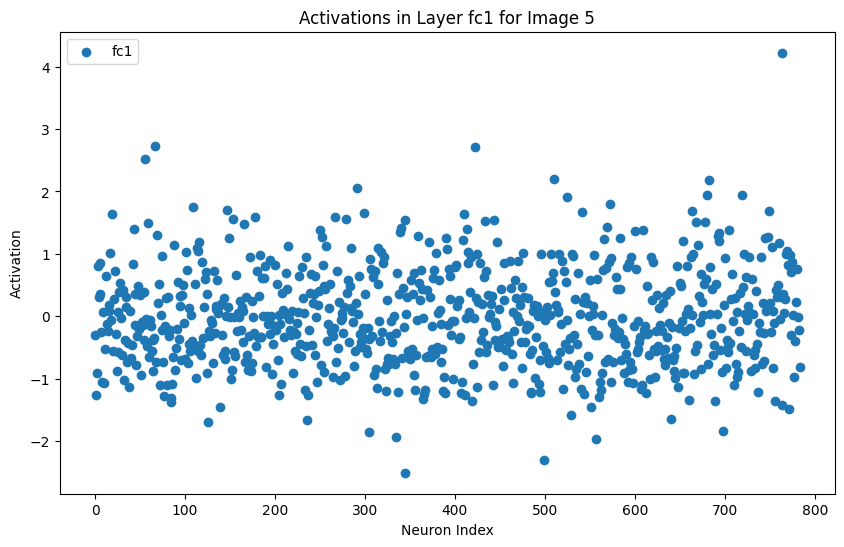

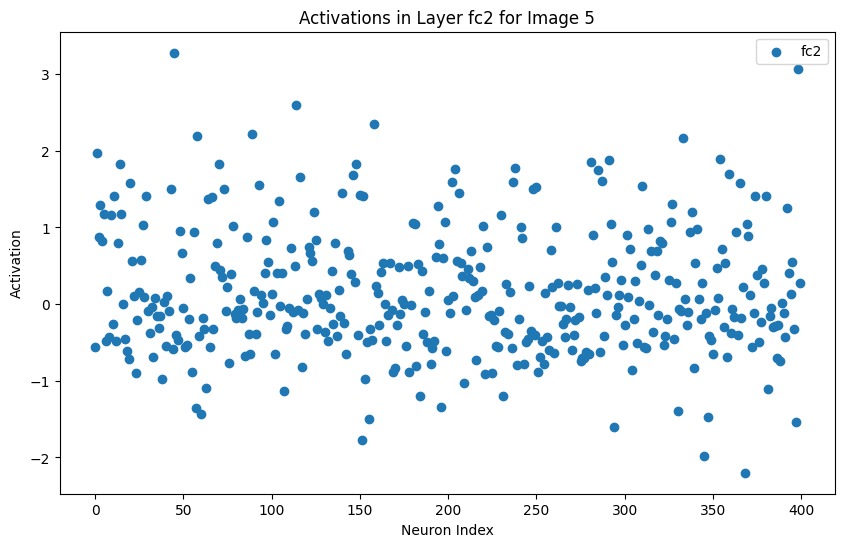

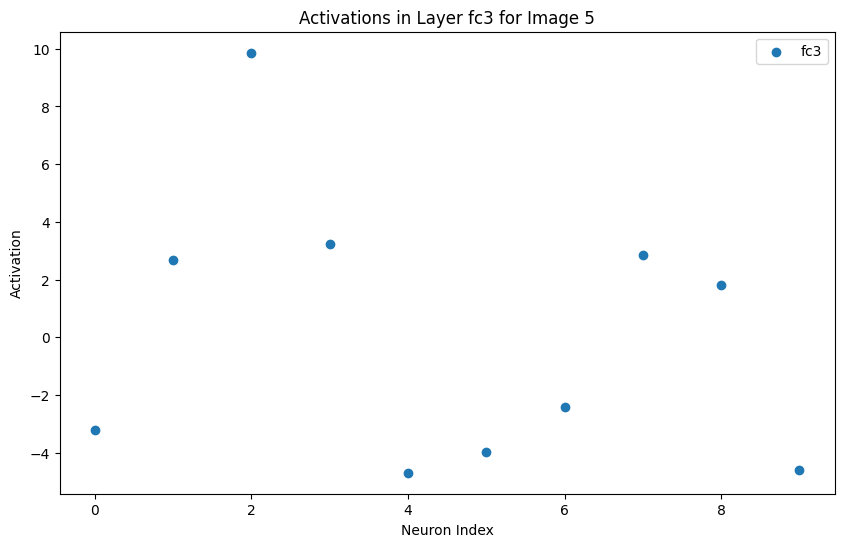

In [6]:
# Displays all activations on all layers for a given image index
xNetwork.visualize_activations_for_input(5)
# Displays all activations on a given layer for a given image index
# xNetwork.visualize_activations_for_input(0, layers=['fc3'])

In [7]:
model.eval()

MNISTNet(
  (layers): ModuleDict(
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=400, bias=True)
    (fc3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [8]:
#xNetwork.print_all_activations()

In [9]:
print(list(xNetwork.activations_per_input.keys())[:5]) 
print(len(list(xNetwork.activations_per_input.keys())))
print(model.layers.keys())
total_images = len(trainloader.dataset)
print(f"Total images in the dataset: {total_images}")

[0, 1, 2, 3, 4]
59968
odict_keys(['fc1', 'fc2', 'fc3'])
Total images in the dataset: 60000


In [10]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchnum, shuffle=False)


def test_accuracy(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

accuracy = test_accuracy(model, testloader)
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 95.25%


In [11]:
temp = xNetwork.find_extreme_activations(std_dev_threshold=2.5)

In [12]:
def print_extreme_activations(extreme_activations):
    for extremity_type in ['high', 'low']:
        print(f"\n{extremity_type.upper()} Extreme Activations:")

        for (layer_name, node_index), input_indices in extreme_activations[extremity_type].items():
            print(f"  Layer: {layer_name}, Node: {node_index}")
            print(f"    Inputs with {extremity_type} activations: {input_indices}")




In [13]:
struct = xNetwork.build_extreme_activation_structure()


High activations count: 1194
Low activations count: 1183
Mismatched Prediction: Input Index 69, Expected: 4, Predicted: 9, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 628, Expected: 0, Predicted: 4, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 2583, Expected: 9, Predicted: 4, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 10250, Expected: 9, Predicted: 4, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 13245, Expected: 3, Predicted: 9, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 15562, Expected: 9, Predicted: 4, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 16516, Expected: 9, Predicted: 4, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 18732, Expected: 4, Predicted: 9, Node: 593, Layer: fc1, High Activation
Mismatched Prediction: Input Index 21534, Expected: 9, Predicted: 4, Node: 593, Layer

In [14]:
# FIXME: Right now the input_hook is called exactly 9920 times more so there are that many more activations (may not actually be a problem)
print(f'activations: {len(xNetwork.activations_per_input)}, inhook: {xNetwork.inhook}')
print(f'gradients: {len(xNetwork.gradients_per_input)}, backhook {xNetwork.backhook}')


activations: 69952, inhook: 3285
gradients: 60032, backhook 5628


In [15]:
def print_activation_structure(struct):
    num_digits = 10
    layer_names = ['fc1', 'fc2', 'fc3']
    extremity_types = ['High', 'Low']

    for digit in range(num_digits):
        print(f"Digit: {digit}")
        for layer_index, layer_name in enumerate(layer_names):
            print(f"  Layer: {layer_name}")
            for ext_index, ext_type in enumerate(extremity_types):
                node_indices = struct[digit][layer_index][ext_index]
                if node_indices:
                    formatted_indices = ', '.join(map(str, node_indices))
                    print(f"    {ext_type} Extreme Activations: Nodes [{formatted_indices}]")
                else:
                    print(f"    {ext_type} Extreme Activations: None")
        print()

print_activation_structure(struct)


Digit: 0
  Layer: fc1
    High Extreme Activations: Nodes [593, 707, 760, 133, 321, 369, 488, 551, 584, 735, 145, 266, 191, 759, 19, 153, 299, 303, 359, 664, 81, 554, 722, 244, 292, 354, 424, 483, 517, 518, 556, 557, 689, 702, 767, 62, 220, 671, 35, 1, 44, 226, 308, 317, 456, 484, 490, 515, 561, 698, 699, 710, 361, 632, 104, 212, 239, 427, 498, 658, 701, 93, 144, 289, 323, 331, 334, 355, 477, 588, 594, 673, 712, 774, 14, 92, 265, 458, 639, 28, 644, 727, 309, 569, 121, 215, 15, 425, 585, 637, 124, 218, 259, 737, 102, 645, 656, 68, 258, 282, 489, 523, 717, 21, 80, 164, 335, 346, 381, 211, 333, 402, 619, 174, 150, 241, 261, 363, 545, 120, 135, 193, 480, 605, 756, 478, 383, 342, 60, 125, 274, 473, 268, 505, 170, 171, 97, 739, 378, 718, 251, 764, 96, 205, 387, 485, 310, 733, 29, 762, 16, 190, 197, 207, 277, 301, 304, 349, 364, 409, 411, 459, 475, 510, 529, 535, 776, 320, 41, 167, 370, 479, 482, 501, 512, 17, 151, 537, 521, 231, 509, 533, 386, 139, 375, 431, 528, 260, 66, 71, 612, 493, 773, 

Digit: 0
  Layer: fc1


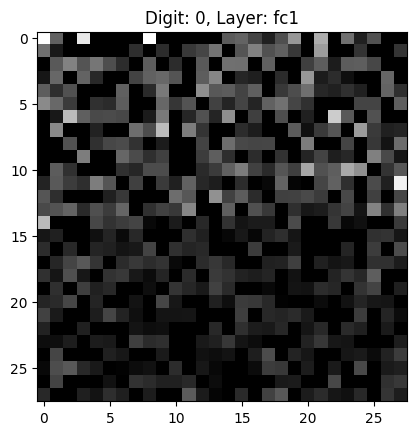

  Layer: fc2


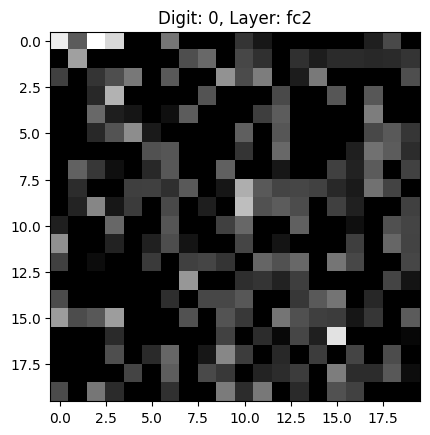

  Layer: fc3


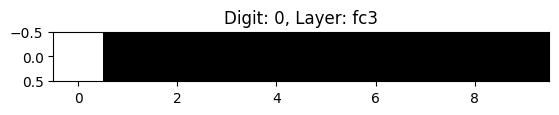


Digit: 1
  Layer: fc1


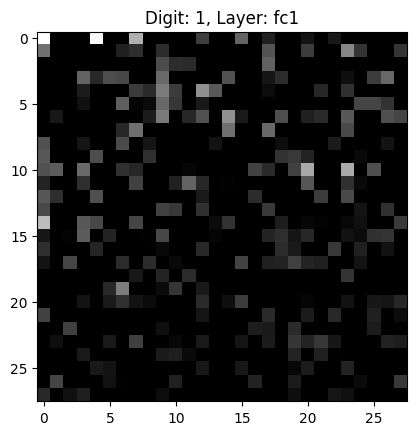

  Layer: fc2


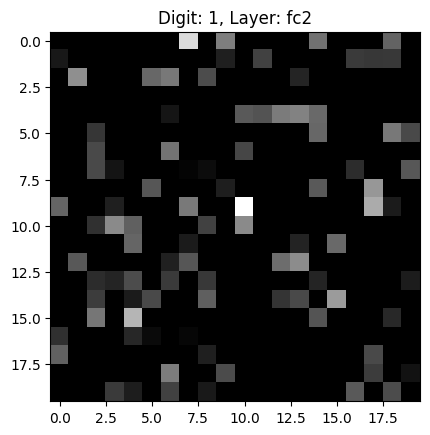

  Layer: fc3


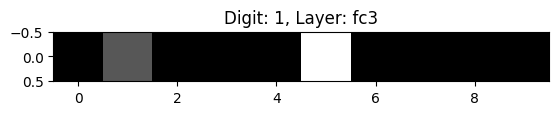


Digit: 2
  Layer: fc1


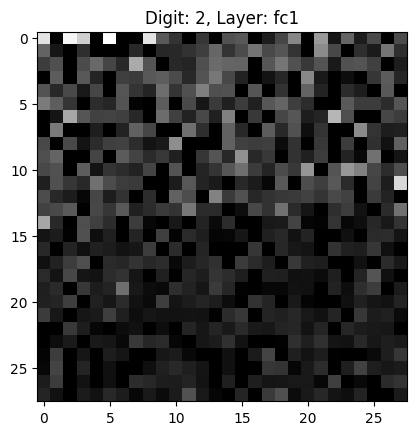

  Layer: fc2


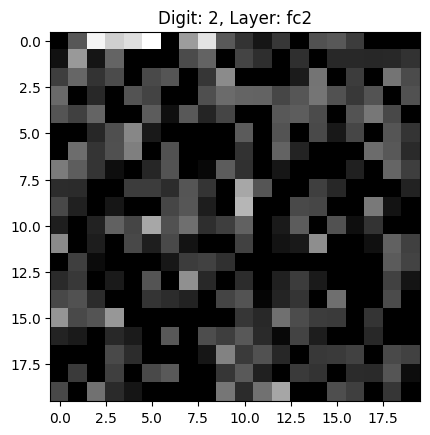

  Layer: fc3


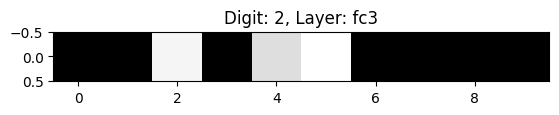


Digit: 3
  Layer: fc1


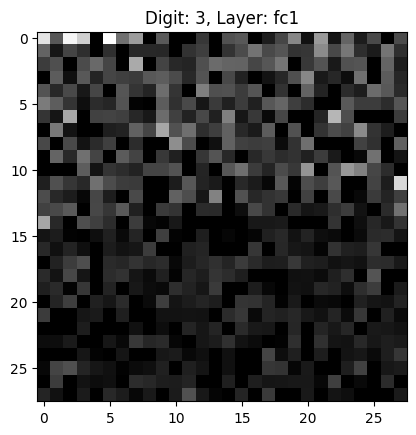

  Layer: fc2


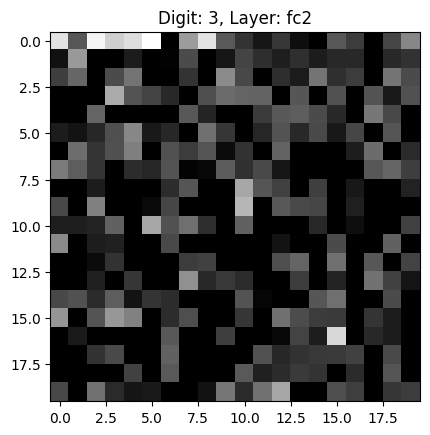

  Layer: fc3


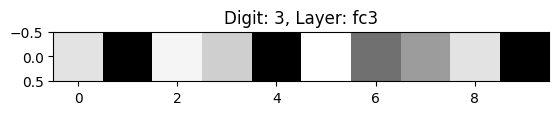


Digit: 4
  Layer: fc1


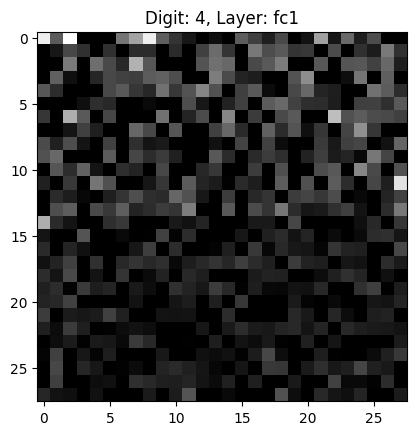

  Layer: fc2


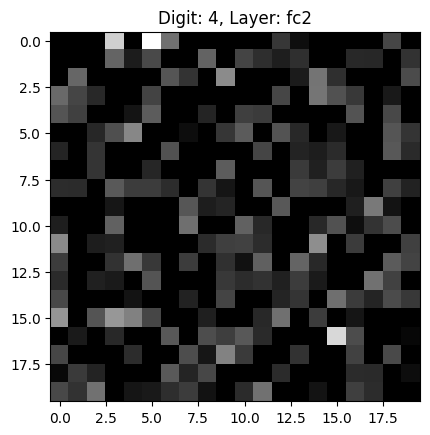

  Layer: fc3


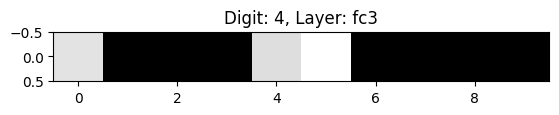


Digit: 5
  Layer: fc1


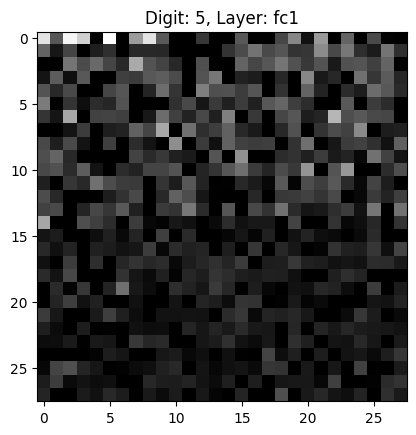

  Layer: fc2


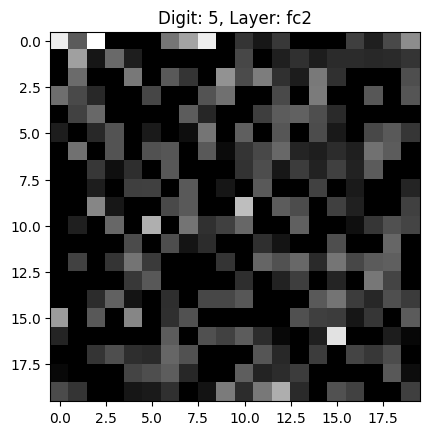

  Layer: fc3


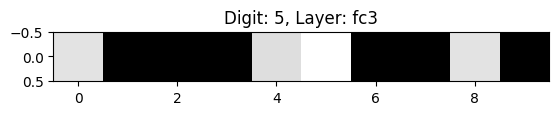


Digit: 6
  Layer: fc1


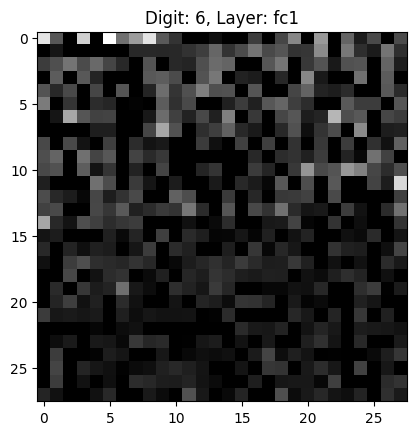

  Layer: fc2


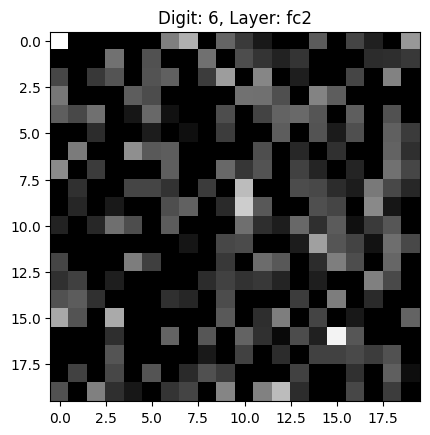

  Layer: fc3


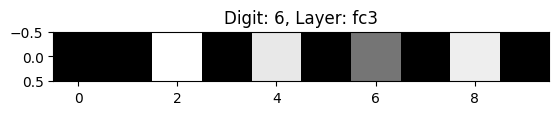


Digit: 7
  Layer: fc1


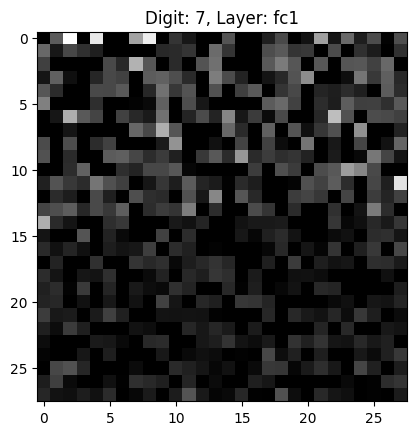

  Layer: fc2


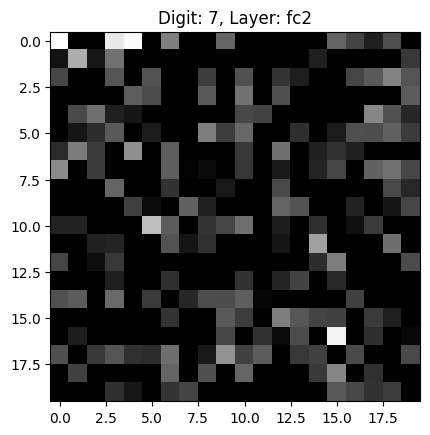

  Layer: fc3


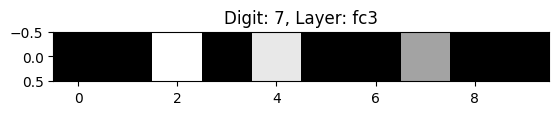


Digit: 8
  Layer: fc1


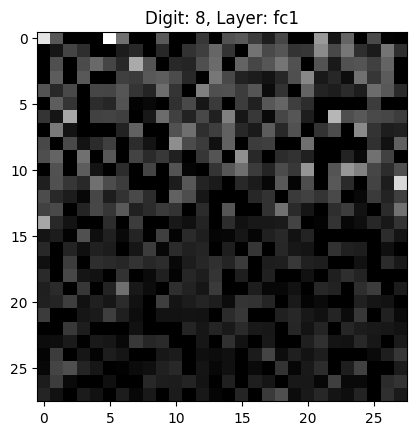

  Layer: fc2


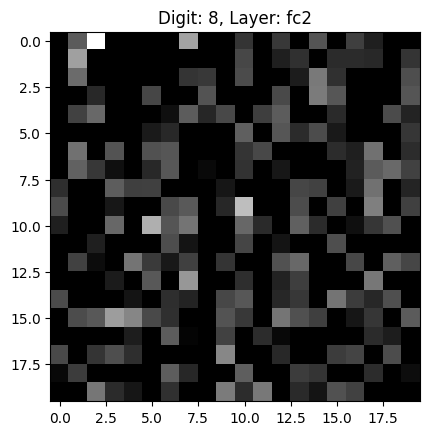

  Layer: fc3


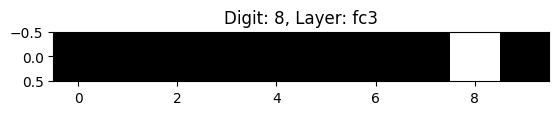


Digit: 9
  Layer: fc1


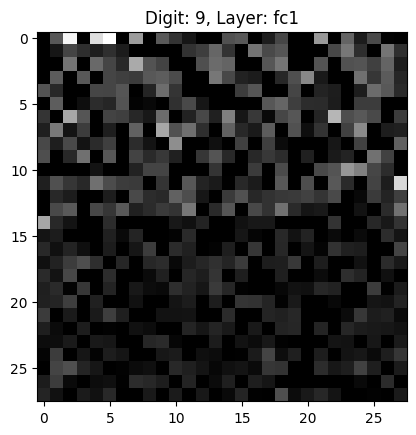

  Layer: fc2


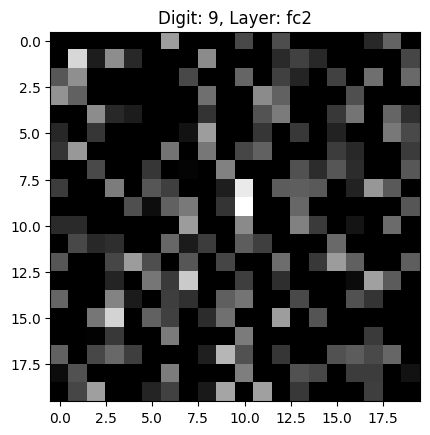

  Layer: fc3


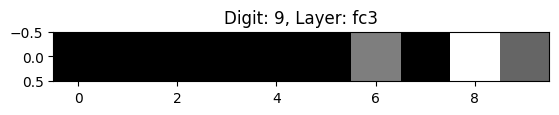

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Displays a greyscale image of the high or low (0 or 1) activations for the digit and layer
def visualizeNodeActivations(struct):
    num_digits = 10
    layer_shapes = [(28, 28), (20, 20), (1, 10)]
    layer_names = ['fc1', 'fc2', 'fc3']
    extremity_types = ['High', 'Low']
    # 0 for high, 1 for low
    ext_index = 0
    for digit in range(num_digits):
        print(f"Digit: {digit}")
        for layer_index, layer_name in enumerate(layer_names):
            print(f"  Layer: {layer_name}")
            
            activation_matrix = np.zeros(layer_shapes[layer_index])
            
            node_indices = struct[digit][layer_index][ext_index]
            
            node_indices = np.array(node_indices)
            
            node_indices = node_indices.astype(int)
            
            # Don't forget to change this line to match with the ext_index above
            # Normalizes the values between 0 and 1 for greyscale coloring
            activation_values = (xNetwork.activation_frequencies['high'] / xNetwork.activation_frequencies['high'].max())[node_indices]
            # activation_values[activation_values > .75] = 1
            # activation_values[activation_values < .3] = 0
            activation_matrix[node_indices // layer_shapes[layer_index][1], 
                                node_indices % layer_shapes[layer_index][1]] = activation_values
            
            
            plt.imshow(activation_matrix, cmap='gray', interpolation='nearest')
            plt.title(f"Digit: {digit}, Layer: {layer_name}")
            plt.show()

        print()

visualizeNodeActivations(struct)

In [17]:
sample_size = 10

print("Sample of Expected Outputs:", xNetwork.expected_outputs[:sample_size])
print("Sample of Predicted Outputs:", xNetwork.predicted_outputs[:sample_size])


Sample of Expected Outputs: [9, 2, 4, 6, 1, 2, 5, 7, 0, 2]
Sample of Predicted Outputs: [9, 2, 4, 6, 1, 2, 5, 7, 0, 7]
